# Data Preparation - Part 2
## 3. Construct data
## 4. Integrate data
## 5. Format data

In [45]:
# StackOverflow Developer Survey - Feature Engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [46]:
print("Feature Engineering for Linear Regression Model")
print("=" * 50)

# Load the cleaned and encoded dataset
print("Loading the dataset...")
df_encoded = pd.read_csv('../data/processed/cleaned_survey_data.csv')
print("Dataset loaded successfully.")
print(f"Initial dataset shape: {df_encoded.shape}")

Feature Engineering for Linear Regression Model
Loading the dataset...
Dataset loaded successfully.
Initial dataset shape: (23928, 449)


In [47]:
# 1. Create Career Satisfaction Features
print("\n1. Creating Career Satisfaction Features...")


1. Creating Career Satisfaction Features...


In [48]:
def count_semicolon_items(series):
    """Count number of items in semicolon-seperated string"""
    def count_items(x):
        if pd.isna(x) or x == '' or str(x).lower() == 'nan':
            return 0
        return len([item.strip() for item in str(x).split(';') if item.strip()])
    return series.apply(count_items)

In [49]:
def create_satisfaction_feature(have_col, want_col, feature_name):
    """
    Create satisfaction feature comparing what they have vs what they want to work with
    :return: 0 = same (satisfied), 1 = want more (growth mindset), -1 = want less (simplification)
    """
    have_counts = count_semicolon_items(df_encoded[have_col])
    want_counts = count_semicolon_items(df_encoded[want_col])
    
    # Create the comparison feature
    satisfaction = np.where(want_counts > have_counts, 1, # Want more (growth)
                            np.where(want_counts < have_counts, -1, # Want less (simplification)
                                     0)) # Same (satisfied)
    
    # Create additional metric
    difference = want_counts - have_counts
    ratio = np.where(have_counts > 0, want_counts / have_counts,
                     np.where(want_counts > 0, 2, 1)) # handle division by zero
    
    print(f"{feature_name}:")
    print(f"  Growth mindset (want more): {(satisfaction == 1).sum()} ({(satisfaction == 1).mean()*100:.1f}%)")
    print(f"  Satisfied (same amount): {(satisfaction == 0).sum()} ({(satisfaction == 0).mean()*100:.1f}%)")
    print(f"  Simplification (want less): {(satisfaction == -1).sum()} ({(satisfaction == -1).mean()*100:.1f}%)")
    
    return satisfaction, difference, ratio

In [50]:
# Create satisfaction features for each domain
satisfaction_features = {}

# Languages
if 'LanguageHaveWorkedWith' in df_encoded.columns and 'LanguageWantToWorkWith' in df_encoded.columns:
    lang_satisfaction, lang_diff, lang_ratio = create_satisfaction_feature(
        'LanguageHaveWorkedWith', 'LanguageWantToWorkWith', 'Languages'
    )
    satisfaction_features.update({
        'Language_Satisfaction': lang_satisfaction,
        'Language_Difference': lang_diff,
        'Language_Ratio': lang_ratio
    })
    
# Databases
if 'DatabaseHaveWorkedWith' in df_encoded.columns and 'DatabaseWantToWorkWith' in df_encoded.columns:
    db_satisfaction, db_diff, db_ratio = create_satisfaction_feature(
        'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith', 'Databases'
    )
    satisfaction_features.update({
        'Database_Satisfaction': db_satisfaction,
        'Database_Difference': db_diff,
        'Database_Ratio': db_ratio
    })

# Communication Platforms
if 'CommPlatformHaveWorkedWith' in df_encoded.columns and 'CommPlatformWantToWorkWith' in df_encoded.columns:
    comm_satisfaction, comm_diff, comm_ratio = create_satisfaction_feature(
        'CommPlatformHaveWorkedWith', 'CommPlatformWantToWorkWith', 'Communication Platforms'
    )
    satisfaction_features.update({
        'CommPlatform_Satisfaction': comm_satisfaction,
        'CommPlatform_Difference': comm_diff,
        'CommPlatform_Ratio': comm_ratio
    })
    
# Add satisfaction features to dataframe
for feature_name, feature_values in satisfaction_features.items():
    df_encoded[feature_name] = feature_values
    
print(f"Created {len(satisfaction_features)} career satisfaction features")

Languages:
  Growth mindset (want more): 4664 (19.5%)
  Satisfied (same amount): 6237 (26.1%)
  Simplification (want less): 13027 (54.4%)
Databases:
  Growth mindset (want more): 3602 (15.1%)
  Satisfied (same amount): 11395 (47.6%)
  Simplification (want less): 8931 (37.3%)
Communication Platforms:
  Growth mindset (want more): 1173 (4.9%)
  Satisfied (same amount): 11355 (47.5%)
  Simplification (want less): 11400 (47.6%)
Created 9 career satisfaction features


In [51]:
# 2. Remove semicolon-separated string columns
print("\n2. Identifying and removing semicolon-separated string columns...")

# identify columns with semicolon-separated strings
semicolon_cols = []
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        # Check if column contains semicolons
        sample_values = df_encoded[col].dropna().head(100)
        if any(';' in str(val) for val in sample_values):
            semicolon_cols.append(col)
            
print(f"Found {len(semicolon_cols)} semicolon-separated columns:")
for col in semicolon_cols:
    print(f"  -  {col}")
    
# Remove these columns
df_features = df_encoded.drop(columns=semicolon_cols)
print(f"Removed {len(semicolon_cols)} semicolon-separated columns")
print(f"Dataset shape after removal: {df_features.shape}")


2. Identifying and removing semicolon-separated string columns...
Found 14 semicolon-separated columns:
  -  EmploymentAddl
  -  LearnCode
  -  LanguageHaveWorkedWith
  -  LanguageWantToWorkWith
  -  LanguageAdmired
  -  DatabaseHaveWorkedWith
  -  DatabaseWantToWorkWith
  -  PlatformHaveWorkedWith
  -  WebframeHaveWorkedWith
  -  OpSysPersonal use
  -  OpSysProfessional use
  -  CommPlatformHaveWorkedWith
  -  CommPlatformWantToWorkWith
  -  SO_Dev_Content
Removed 14 semicolon-separated columns
Dataset shape after removal: (23928, 444)


In [52]:
# 3. Handle remaining categorical variables
print("\n3. Processing remaining categorical variables...")

# Identify remaining object columns
object_cols = df_features.select_dtypes(include=['object']).columns.tolist()
print(f"Remaining object columns: {len(object_cols)}")

# Handle remaining categorical columns
for col in object_cols:
    unique_vals = df_features[col].nunique()
    print(f"  {col}: {unique_vals} unique values")
    
    if unique_vals <= 10:  # Low cardinality - one-hot encode
        dummies = pd.get_dummies(df_features[col], prefix=col, drop_first=True)
        df_features = pd.concat([df_features.drop(columns=[col]), dummies], axis=1)
    else:  # High cardinality - frequency encoding
        freq_encoding = df_features[col].value_counts()
        df_features[f'{col}_frequency'] = df_features[col].map(freq_encoding)
        df_features = df_features.drop(columns=[col])

print(f"Dataset shape after categorical encoding: {df_features.shape}")


3. Processing remaining categorical variables...
Remaining object columns: 3
  DevType: 32 unique values
  Industry: 16 unique values
  Country: 164 unique values
Dataset shape after categorical encoding: (23928, 444)


In [53]:
# 5. Feature scaling and preparation for Linear Regression
print("\n5. Preparing features for Linear Regression...")

# Separate target variable
target_col = 'ConvertedCompYearly'
if target_col in df_features.columns:
    y = df_features[target_col]
    X = df_features.drop(columns=[target_col])
    
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
else:
    print(f"Error: Target column '{target_col}' not found!")
    print("Available columns:", df_features.columns.tolist()[:10], "...")
    # Exit early if target column not found
    raise ValueError(f"Target column '{target_col}' not found in dataset")

# Check for infinite values
inf_cols = []
for col in X.select_dtypes(include=[np.number]).columns:
    if np.isinf(X[col]).any():
        inf_cols.append(col)
        X[col] = X[col].replace([np.inf, -np.inf], np.nan)

if inf_cols:
    print(f"Replaced infinite values in {len(inf_cols)} columns with NaN")
    # Fill the NaN values created from infinite values
    X = X.fillna(X.median())

# Remove constant columns (zero variance)
constant_cols = []
for col in X.columns:
    if X[col].std() == 0:
        constant_cols.append(col)

if constant_cols:
    X = X.drop(columns=constant_cols)
    print(f"Removed {len(constant_cols)} constant columns")


5. Preparing features for Linear Regression...
Features shape: (23928, 443)
Target shape: (23928,)


In [54]:
# 6. Feature selection
print("\n6. Feature selection...")

# Remove highly correlated features
print("Removing highly correlated features...")
numeric_features = X.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr().abs()

# Find pairs of highly correlated features
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.95
high_corr_features = [
    column for column in upper_triangle.columns 
    if any(upper_triangle[column] > 0.95)
]

if high_corr_features:
    X = X.drop(columns=high_corr_features)
    print(f"Removed {len(high_corr_features)} highly correlated features")

print(f"Final feature set shape: {X.shape}")


6. Feature selection...
Removing highly correlated features...
Removed 3 highly correlated features
Final feature set shape: (23928, 440)


In [55]:
# 7. Feature scaling
print("\n7. Feature scaling...")

# Use RobustScaler for better handling of outliers
scaler = RobustScaler()
feature_names = X.columns.tolist()

# Split data first to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

print("Features scaled using RobustScaler")



7. Feature scaling...
Training set: (19142, 440)
Test set: (4786, 440)
Features scaled using RobustScaler


In [56]:
# 8. Final feature selection using statistical tests
print("\n8. Final feature selection...")

# Use SelectKBest with f_regression for feature selection
n_features = min(100, X_train_scaled.shape[1])  # Select top 100 features or all if less
selector = SelectKBest(score_func=f_regression, k=n_features)

X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

print(f"Selected {len(selected_features)} best features")
print("Top 10 features by F-score:")
feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'f_score': feature_scores
}).sort_values('f_score', ascending=False)

print(feature_importance_df.head(10))

# Convert selected features back to DataFrames
X_train_final = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_final = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)


8. Final feature selection...
Selected 100 best features
Top 10 features by F-score:
                                              feature      f_score
99                                  Country_frequency  7290.733241
1                                           YearsCode  3247.874148
0                                             WorkExp  2641.358279
83                 SODuration_Between 10 and 15 years   943.552343
87  SODuration_More than 15 years, or since Stack ...   897.611304
84                   SODuration_Between 3 and 5 years   816.722427
64                                 Employment_Student   644.583733
34                   PlatformHaveWorkedWith_Terraform   639.048193
60                                Age_35-44 years old   603.433936
31                    PlatformHaveWorkedWith_Homebrew   581.184334


In [57]:
# 9. Summary and export
print("\n9. Feature Engineering Summary")
print("=" * 40)
print(f"Original dataset shape: {df_encoded.shape}")
print(f"After removing semicolon columns: {df_features.shape}")
print(f"After preprocessing: {X.shape}")
print(f"Final training features: {X_train_final.shape}")
print(f"Final test features: {X_test_final.shape}")
print(f"Career satisfaction features created: {len(satisfaction_features)}")
print(f"Semicolon columns removed: {len(semicolon_cols)}")


9. Feature Engineering Summary
Original dataset shape: (23928, 458)
After removing semicolon columns: (23928, 444)
After preprocessing: (23928, 440)
Final training features: (19142, 100)
Final test features: (4786, 100)
Career satisfaction features created: 9
Semicolon columns removed: 14


In [58]:
# Display career satisfaction feature distributions
print("\nCareer Satisfaction Feature Summary:")
for feature in satisfaction_features.keys():
    if feature in df_encoded.columns:
        print(f"{feature}: Mean = {df_encoded[feature].mean():.3f}, Std = {df_encoded[feature].std():.3f}")


Career Satisfaction Feature Summary:
Language_Satisfaction: Mean = -0.350, Std = 0.786
Language_Difference: Mean = -1.519, Std = 3.470
Language_Ratio: Mean = 0.839, Std = 0.751
Database_Satisfaction: Mean = -0.223, Std = 0.689
Database_Difference: Mean = -0.610, Std = 2.278
Database_Ratio: Mean = 0.961, Std = 0.773
CommPlatform_Satisfaction: Mean = -0.427, Std = 0.585
CommPlatform_Difference: Mean = -1.356, Std = 2.264
CommPlatform_Ratio: Mean = 0.781, Std = 0.393


In [59]:
# Save processed data for modeling notebook
print("\n10. Saving processed data...")

# Save the processed datasets
X_train_final.to_csv('../data/processed/X_train_processed.csv', index=False)
X_test_final.to_csv('../data/processed/X_test_processed.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

# Save feature names and scaler for future use
import joblib
joblib.dump(scaler, '../data/processed/feature_scaler.pkl')
joblib.dump(selector, '../data/processed/feature_selector.pkl')

# Save feature engineering metadata
metadata = {
    'selected_features': selected_features,
    'career_satisfaction_features': list(satisfaction_features.keys()),
    'removed_semicolon_columns': semicolon_cols,
    'feature_importance': feature_importance_df.to_dict('records'),
    'scaling_method': 'RobustScaler',
    'feature_selection_method': f'SelectKBest_f_regression_top_{n_features}'
}

import json
with open('../data/processed/feature_engineering_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Feature engineering complete!")
print("Files saved:")
print("  - X_train_processed.csv")
print("  - X_test_processed.csv") 
print("  - y_train.csv")
print("  - y_test.csv")
print("  - feature_scaler.pkl")
print("  - feature_selector.pkl")
print("  - feature_engineering_metadata.json")
print("\nReady for modeling notebook!")


10. Saving processed data...
Feature engineering complete!
Files saved:
  - X_train_processed.csv
  - X_test_processed.csv
  - y_train.csv
  - y_test.csv
  - feature_scaler.pkl
  - feature_selector.pkl
  - feature_engineering_metadata.json

Ready for modeling notebook!



11. Visualizing Career Satisfaction Features...


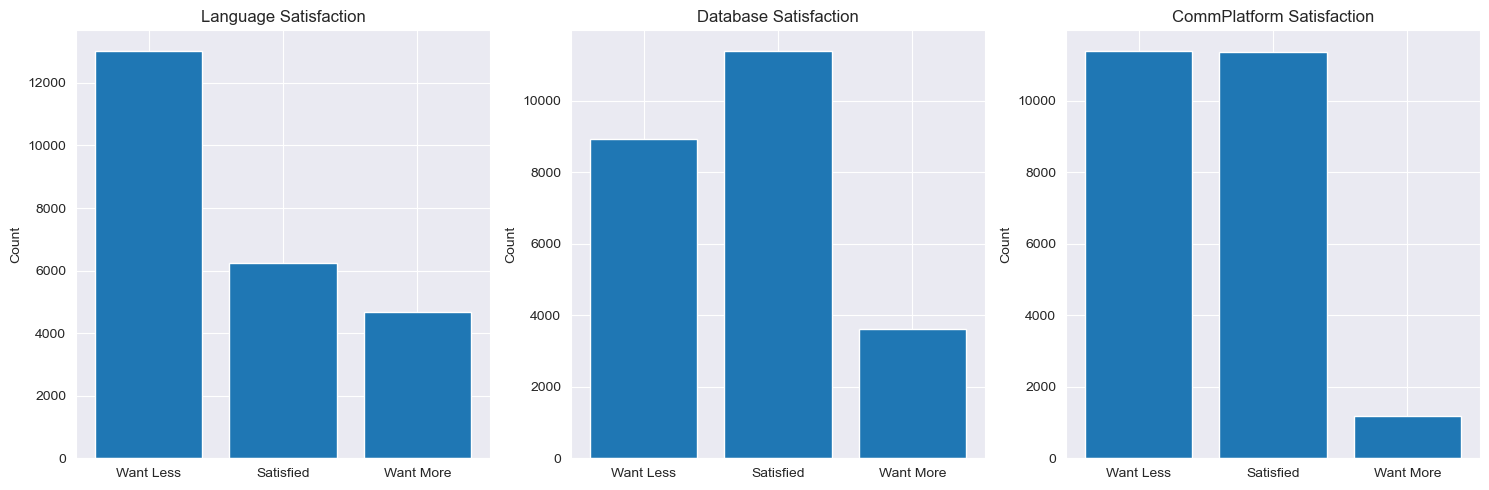

Career satisfaction visualization saved as 'career_satisfaction_distribution.png'


In [60]:
# Quick visualization of career satisfaction features
print("\n11. Visualizing Career Satisfaction Features...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

satisfaction_cols = [col for col in satisfaction_features.keys() if 'Satisfaction' in col]

for i, col in enumerate(satisfaction_cols):
    if col in df_encoded.columns:
        value_counts = df_encoded[col].value_counts().sort_index()
        labels = ['Want Less', 'Satisfied', 'Want More']
        axes[i].bar(range(len(value_counts)), value_counts.values)
        axes[i].set_title(f'{col.replace("_", " ")}')
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(labels)
        axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('../data/processed/career_satisfaction_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Career satisfaction visualization saved as 'career_satisfaction_distribution.png'")